# 実験準備

## 環境構築

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.9 MB/s eta 0:00:00


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.9/615.9 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 94.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=a67629358fdc44c437d5e70efc7ded025216e1fb21b470a732bdd1738a5a4613
  Stored in directory: /root/.cache/pip/wheels/45/b7/f5/a21e68db846eedcd00d69e37d60bab3f68eb20b1d99cdff652
Successfully built ipadic


In [ ]:
!pip install bert-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 KB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from transformers import BertJapaneseTokenizer, BertForMaskedLM, pipeline
from transformers import AdamW

### モデルのダウンロード

In [ ]:
# Ref: https://huggingface.co/transformers/training.html#pytorch

model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"
model = BertForMaskedLM.from_pretrained(model_name)
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name) 

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

In [ ]:
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## データ読み込み

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folda_pass = '/content/drive/MyDrive/実験/learn_data/'
filename = 'original_double.txt'
with open(folda_pass+filename)as f:
  original = f.readlines()
  print(original[0])

疲れてヘトヘトとかけまして、空手家とときます。その心は、どちらも、「いたわり」（労り、板割り）が必要です。



In [ ]:
filename = 'Double_MASK.txt'
with open(folda_pass+filename)as f:
  double_mask = f.readlines()
  print(double_mask[0])


疲れてヘトヘトとかけまして、空手家とときます。その心は、どちらも、「いたわり」(労り、板割り)[MASK][MASK]です。



In [ ]:
filename = 'SINGLE_MASK_AFTER.txt'
with open(folda_pass+filename)as f:
  single_mask_texts = f.readlines()
  print(single_mask_texts[0])

疲れてヘトヘトとかけまして、空手家とときます。その心は、どちらも、「いたわり」(労り、板割り)が[MASK]です。



## データ整理

In [ ]:
print(len(original))
print(len(single_mask_texts))

207
207


In [ ]:
#先にテストデータ、評価データを作る
#8:1:1(train_dataは後に後に3倍になるため倍になるため*3する)
ACC_ratio = (len(original)//10)*1
test_ratio = (len(original)//10)*1 + ACC_ratio
#val
Acc_docs_singele = single_mask_texts[:ACC_ratio]
Acc_labels = original[:ACC_ratio]
Acc_double = double_mask[:ACC_ratio]
#test
test_docs_singele = single_mask_texts[ACC_ratio:test_ratio]
test_labels = original[ACC_ratio:test_ratio]
test_double = double_mask[ACC_ratio:test_ratio]
#train
train_singele = single_mask_texts[test_ratio:]
original_texts = original[test_ratio:]

In [ ]:
test_double

['お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)[MASK][MASK]です。\n',
 '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)[MASK][MASK]ます。\n',
 '天秤とかけまして、赤ちゃんとときます。その心は、どちらも、「おもり」(重り、お守り)[MASK][MASK]です。\n',
 '自転車とかけまして、新聞とときます。その心は、どちらも、「ほうち」(放置、報知)[MASK][MASK]でしょう。\n',
 '花火とかけまして、仕事終わりとときます。その心は、どちらも、「うちあげ」(打ち上げ)[MASK][MASK]ます。\n',
 '柔道とかけまして、禁煙とときます。その心は、どちらも、「いっぽん」(一本)[MASK][MASK]です。\n',
 'クリーニング屋とかけまして、笑顔とときます。その心は、どちらも、「ふく」(服、福)[MASK][MASK]ます。\n',
 '株式とかけまして、お皿とときます。その心は、どちらも、「とうき」(投機、陶器)[MASK][MASK]ます。\n',
 'チャンピョンとかけまして、大掃除とときます。その心は、どちらも、「ほこり」(誇り、[UNK])[MASK][MASK]ます。\n',
 '賭け事とかけまして、真夜中とときます。その心は、どちらも、「つき」(ツキ、月)[MASK][MASK]でしょう。\n',
 '電気自動車とかけまして、野球とときます。その心は、どちらも、「ばってりー」(バッテリー)[MASK][MASK]です。\n',
 'そうめんとかけまして、月とときます。その心は、どちらも、「つゆ」(汁、梅雨)[MASK][MASK]ます。\n',
 '秋とかけまして、怒りとときます。その心は、どちらも、「こうよう」(紅葉、高揚)[MASK][MASK]ます。\n',
 'オーディションとかけまして、お彼岸とときます。その心は、どちらも、「せんこう」(選考、線香)[MASK][MASK]ます。\n',
 '祭りとかけまして、みそ汁とときます。その心は、どちらも、「だし」(山車、ダシ)[MASK][MASK]です。\n',
 '食堂とかけまして、不祥事事件とときます。その心は、どちらも、「ていしょく」(定食、停職)[MASK

In [ ]:
train_docs_single = train_singele
train_labels = original_texts


print(" single訓練データ")
print(len(train_docs_single),len(train_labels))
print("評価データ")
print(len(Acc_docs_singele),len(Acc_labels))
print("テストデータ")
print(len(test_docs_singele),len(test_labels))

 single訓練データ
167 167
評価データ
20 20
テストデータ
20 20


In [ ]:
#テストで使うデータ
all_add_ZYOSI = []
ZYOSI = ['が','を','に','の','へ','と','から','より','で','や']
for j in test_double:
  add_ZYOSI=[]
  for i in ZYOSI:
    zyosi_text = j.replace("[MASK]",i,1)
    add_ZYOSI.append(zyosi_text)
    #print(zyosi_text)
  all_add_ZYOSI.append(add_ZYOSI)
  # print(add_ZYOSI)


In [ ]:
print(len(all_add_ZYOSI))
print(all_add_ZYOSI)

20
[['お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)が[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)を[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)に[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)の[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)へ[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)と[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)から[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)より[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)で[MASK]です。\n', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)や[MASK]です。\n'], ['忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)が[MASK]ます。\n', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)を[MASK]ます。\n', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)に[MASK]ます。\n', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)の[MASK]ます。\n', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)へ[MASK]ます。\n', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)と[MASK]ます。\n', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)から[MASK]ます。\n', '忍者とかけまして

## 形態素解析

In [ ]:
encodings = tokenizer(train_docs_single, return_tensors='pt', padding=True, truncation=True, max_length=64)
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
encodings = tokenizer(train_labels, return_tensors='pt', padding=True, truncation=True, max_length=64)
labels = encodings['input_ids']
print(input_ids[0])

tensor([    2,  1414, 17703,    13,  2111,  3913,    16,     6,  6804,   167,
           13,   900,  2610,     8,    59,  1052,     9,     6,  3788,    28,
            6,    36,   191, 19070,  5393, 20463,     6,   371, 29100,    24,
           14,     4,  2992,     8,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
encodings = tokenizer(Acc_docs_singele, return_tensors='pt', padding=True, truncation=True, max_length=64)
acc_input_ids = encodings['input_ids']
acc_attention_mask = encodings['attention_mask']
encodings = tokenizer(Acc_labels, return_tensors='pt', padding=True, truncation=True, max_length=64)
acc_labels = encodings['input_ids']

In [ ]:
print(len(acc_input_ids[1]))
print(len(acc_labels[1]))

41
41


In [ ]:
encodings = tokenizer(test_docs_singele, return_tensors='pt', padding="max_length", truncation=True, max_length=64)
test_input = encodings['input_ids']
encodings = tokenizer(test_labels, return_tensors='pt', padding="max_length", truncation=True, max_length=64)
Test_labels = encodings['input_ids']

In [ ]:
print(len(test_input[1]))
print(len(Test_labels[1]))

64
64


In [ ]:
zyosi_input_list = []
for zyosi_nazokake in all_add_ZYOSI:
  encodings = tokenizer(zyosi_nazokake, return_tensors='pt', padding="max_length", truncation=True, max_length=64)
  zyosi_input = encodings['input_ids']
  zyosi_input_list.append(zyosi_input)

## 関数定義

In [ ]:
"""
リストが一致しているかしているかboolで返す
"""
def MatchList(list1,list2):
  for i in range(len(list1)):
    if list1[i] != list2[i]:
      return False
  return True

"""
model:model
input:入力データ
tokenizer:トークナイザ
label:ラベル
"""
def predict(model,tokenizer,input,label):
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=64)
  input_ids = encodings['input_ids']
  encodings = tokenizer(label, return_tensors='pt', padding=True, truncation=True, max_length=64)
  label_ids = encodings['input_ids']
  count = 0
  bunbo = 0
  batch = 16
  num = len(input_ids)//batch + 1
  correctAnswer = [] #正解したのを保存するリスト
  All_return_result = []
  for b in range(num):#bacthに分けて学習するためnumの回数繰り返す
    section = batch*b
    section2 = section+batch
    batch_input_ids = input_ids[section:section2]
    if(b == num-1):
      batch_input_ids = input_ids[section:]

    with torch.no_grad():
      outputs = model(batch_input_ids)

    masked_position = (batch_input_ids.squeeze() == tokenizer.mask_token_id).nonzero() #これでマスク部分の抽出ができるらしい
    last_hidden_state = outputs[0].squeeze()#出力

    masked_pos = []
    [masked_pos.append([])for _ in range(masked_position[-1][0]+1)]

    for i in masked_position:
        masked_pos[i[0].item()].append(i[1].item())


    topk = 1
    for index,mask_index in enumerate(masked_pos):
      result=[]
      answer=[]
      
      for i in mask_index:
        mask_hidden_state = last_hidden_state[index][i] # 詳細結果の参照
        idx = torch.topk(mask_hidden_state, k=topk, dim=0)[1] # 予測結果の上位を出力
        words = [tokenizer.decode(i.item()).strip() for i in idx]
        result.append(words[0])
        answer_words = tokenizer.decode(label_ids[index+section][i].item()).strip()
        answer.append(answer_words)

      result_docs = input[index+section]
      for i in result:
        i=i.replace(" ","")
        result_docs = result_docs.replace('[MASK]',i,1)
      if(MatchList(result,answer)):
        count += 1
        correctAnswer.append(result_docs.replace("\n",""))
      return_result = [result,answer,result_docs.replace("\n",""),label[index+section].replace("\n","")]
      All_return_result.append(return_result)
      bunbo += 1
  print(str(count)+"/"+str(bunbo))
  score = count/bunbo
  return {"分数":str(count)+"/"+str(bunbo),"スコア":score,"正解リスト":correctAnswer,"予測":All_return_result}

In [ ]:
import re
import numpy as np
def calc_score(text,MLM):
  tokenized_text1=tokenizer.tokenize(text) # 文章を形態素解析
  for i in range(len(tokenized_text1)):
    provisional=tokenized_text1[i] # マスクする部分を一時的に保持する変数
    tokenized_text1[i]='[MASK]' # 一単語をマスクする
    text=''.join(tokenized_text1) # リストになっているので、連結して一つの文にする
    score=re.findall(r'\d+\.\d+',str(MLM(text)[0])) # 解析結果の中から小数を抜き出す
    score1=+np.log(float(score[0])/len(tokenized_text1)) #生起確率を足し合わせる
    tokenized_text1[i]=provisional # マスクした単語を元に戻す
  return score1
"""
model:model
tokenizer:トークナイザ
input:入力データ(助詞の種類だけある)
label:ラベル(1つ)
"""
def predict_zyosi(model,tokenizer,input,label):
  #config=BertConfig.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking') 
  MLM=pipeline('fill-mask',model=model,tokenizer=tokenizer) # pepeline関数でモデルを利用できるようにする
  model.eval()
  zyosi_input_list = []
  for zyosi_nazokake in input:
    encodings = tokenizer(zyosi_nazokake, return_tensors='pt', padding="max_length", truncation=True, max_length=64)
    zyosi_input = encodings['input_ids']
    zyosi_input_list.append(zyosi_input)
  encodings = tokenizer(label, return_tensors='pt', padding=True, truncation=True, max_length=64)
  label_ids = encodings['input_ids']
  #print(zyosi_input_list)

  count = 0
  bunbo = 0

  correctAnswer = [] #正解したのを保存するリスト
  All_return_result = []

  for ind,zyosi_nazokake_ids in enumerate(zyosi_input_list):#謎かけごとに分けて学習する
    with torch.no_grad():
      outputs = model(zyosi_nazokake_ids)

    masked_position = (zyosi_nazokake_ids.squeeze() == tokenizer.mask_token_id).nonzero()[0][1] #これでマスク部分の抽出ができるらしい
    mask_index = masked_position
    last_hidden_state = outputs[0].squeeze()#出力

    topk = 1
    result_list = []
    top = [-100,0]
    for index in range(len(zyosi_nazokake_ids)):
      result = []
      mask_hidden_state = last_hidden_state[index][mask_index] # 詳細結果の参照
      idx = torch.topk(mask_hidden_state, k=topk, dim=0)[1] # 予測結果の上位を出力
      word = tokenizer.decode(idx.item()).strip() #予測単語
      result.append(word.replace(" ",""))#resultに単語を格納

      #予測した単語を文章に当てはめる
      result_docs = input[ind][index]
      result_docs = result_docs.replace('[MASK]',word.replace(" ",""),1).replace("\n","")
      tensuu = calc_score(result_docs,MLM)
      if top[0] < tensuu:
        top[0] = tensuu
        top[1] = index
      result.append(result_docs)
      result.append(tensuu)

      print(result)
      result_list.append(result)
    print(top)
    top_docs = [result_list[top[1]],ZYOSI[top[1]]]
    answer_docs = label[ind].replace("\n","")
    answer_words = tokenizer.decode(label_ids[ind][mask_index].item()).strip()#答えの単語を確認
    #answer.append(answer_words)#答えの単語を格納答えの単語を格納
    return_result = [answer_words,answer_docs,result_list,top_docs]
    print(top_docs)
    All_return_result.append(return_result)
    bunbo += 1
        
        # if(MatchList(result,answer)):
        #   count += 1
        #   correctAnswer.append(result_docs.replace("\n",""))
    
  print(str(count)+"/"+str(bunbo))
  score = count/bunbo
  return {"分数":str(count)+"/"+str(bunbo),"スコア":score,"正解リスト":correctAnswer,"予測":All_return_result}

## ファインチューニング前に一度結果を確認

In [ ]:
test_result = predict(model,tokenizer,test_docs_singele,test_labels)

11/20


In [ ]:
print(len(test_result))
print(test_result["予測"])
for i in test_result["予測"]:
  print(i)

In [ ]:
s = predict_zyosi(model,tokenizer,all_add_ZYOSI[:1],test_labels[:1])

['ない', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)がないです。', -3.6550151821785084]
['好き', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)を好きです。', -3.6493065086628755]
['可', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)に可です。', -3.6564740917963072]
['よう', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)のようです。', -3.6472215069946894]
['そう', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)へそうです。', -3.6687840321280354]
['も', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)ともです。', -3.6274074431936905]
['そう', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)からそうです。', -3.656122826670425]
['[UNK]', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)より[UNK]です。', -3.6519599909453775]
['そう', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)でそうです。', -3.658360059670205]
['[UNK]', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)や[UNK]です。', -3.6460921727331015]
[-3.6274074431936905, 5]
[['も', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)ともです。', -3.6274074431936905]]
0/1


# 実験

## ファインチューニング

### 定義

In [ ]:
import numpy as np


def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### ファインチューニング

In [ ]:
model.train()
outputs = model(input_ids[:1], attention_mask=attention_mask[:1], labels=labels[:1])
print(outputs.loss)

tensor(8.9280, grad_fn=<NllLossBackward0>)


In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-5)
early_stopping = EarlyStopping(patience=3)
epoch = 100
batch = 16
num = len(input_ids)//batch
loss_list = []
acc_loss = []
test_acc = []
val_acc = []
train_acc = []
zyosi_acc = []
result_list = [[],[],[],[]]

for i in range(epoch):#epochの数だけ繰り返す
  print("-----------epoch"+str(i+1)+"----------")
  # test_result =  test_acc.append(predict(model,tokenizer,test_docs_singele,test_labels))
  # train_result = train_acc.append(predict(model,tokenizer,train_singele,original_texts))
  # val_result =  val_acc.append(predict(model,tokenizer,Acc_docs_singele,Acc_labels))
  #助詞
  if i == 8 or i == 11:
    zyosi_test = zyosi_acc.append(predict_zyosi(model,tokenizer,all_add_ZYOSI,test_labels))
    result_list[3].append(zyosi_test)


  # result_list[0].append(test_result)
  # result_list[1].append(train_result)
  # result_list[2].append(val_result)

  for b in range(num):#bacthに分けて学習するためnumの回数繰り返す
    c=b+1
    outputs = model(input_ids[batch*b:batch*c], attention_mask=attention_mask[batch*b:batch*c], labels=labels[batch*b:batch*c])
    loss = outputs.loss
    loss_list.append(loss.item())
    print(loss)
    loss.backward()
    optimizer.step()


  with torch.no_grad():
    outputs = model(acc_input_ids,attention_mask=acc_attention_mask,labels=acc_labels)
  loss = outputs.loss
  acc_loss.append(loss.item())
  print("accののloss")
  print(loss)
  early_stopping(loss, model)
  if early_stopping.early_stop:
    print("Early Stopping")
    break

    
      


-----------epoch1----------
tensor(9.5018, grad_fn=<NllLossBackward0>)
tensor(8.8474, grad_fn=<NllLossBackward0>)
tensor(7.5935, grad_fn=<NllLossBackward0>)
tensor(6.9951, grad_fn=<NllLossBackward0>)
tensor(5.8921, grad_fn=<NllLossBackward0>)
tensor(4.9633, grad_fn=<NllLossBackward0>)
tensor(4.2343, grad_fn=<NllLossBackward0>)
tensor(3.4520, grad_fn=<NllLossBackward0>)
tensor(3.3579, grad_fn=<NllLossBackward0>)
tensor(3.3389, grad_fn=<NllLossBackward0>)
accののloss
tensor(1.5101)
-----------epoch2----------
tensor(2.2864, grad_fn=<NllLossBackward0>)
tensor(2.0521, grad_fn=<NllLossBackward0>)
tensor(1.4529, grad_fn=<NllLossBackward0>)
tensor(1.0688, grad_fn=<NllLossBackward0>)
tensor(0.9268, grad_fn=<NllLossBackward0>)
tensor(0.9139, grad_fn=<NllLossBackward0>)
tensor(1.0518, grad_fn=<NllLossBackward0>)
tensor(1.1175, grad_fn=<NllLossBackward0>)
tensor(1.1232, grad_fn=<NllLossBackward0>)
tensor(1.1854, grad_fn=<NllLossBackward0>)
accののloss
tensor(3.1908)
EarlyStopping counter: 1 out of 3


In [ ]:
zyosi_test = zyosi_acc.append(predict_zyosi(model,tokenizer,all_add_ZYOSI,test_labels))
result_list[3].append(zyosi_test)

['必要', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)が必要です。', -3.6398809469571636]
['狙い', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)を狙いです。', -3.639460036625306]
['必要', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)に必要です。', -3.639701081231132]
['[PAD]', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)の[PAD]です。', -3.6400661032595747]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)へ、です。', -3.639731902818168]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)と、です。', -3.6394721591363584]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)から、です。', -3.6394382403617875]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)より、です。', -3.6394933589547094]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)で、です。', -3.6395380890600397]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)や、です。', -3.6394962254435144]
[-3.6394382403617875, 6]
[['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)から、です。', -3.6394382403617875], 'から']
['あり', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)があります。', -3.46892

# 結果

## 結果の確認

In [ ]:
for i in zyosi_acc[1]["予測"]:
  for k in i[2]:
    print(k)

['必要', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)が必要です。', -3.6398809469571636]
['狙い', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)を狙いです。', -3.639460036625306]
['必要', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)に必要です。', -3.639701081231132]
['[PAD]', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)の[PAD]です。', -3.6400661032595747]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)へ、です。', -3.639731902818168]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)と、です。', -3.6394721591363584]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)から、です。', -3.6394382403617875]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)より、です。', -3.6394933589547094]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)で、です。', -3.6395380890600397]
['、', 'お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)や、です。', -3.6394962254435144]
['あり', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)があります。', -3.468929188759027]
['振り', '忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)を振ります。', -3.4689154957328157]
['行き', '忍者とかけまして、栗とときます。その心は

In [ ]:
filepass='/content/drive/MyDrive/実験/result/パターンB/全助詞データ/'
filename="score_result_epoch8.txt"
with open(filepass+filename, mode='w') as f:
  for j in zyosi_acc[0]["予測"]:
    f.write("---\n")
    f.write("答え　　："+j[0]+"\n") 
    f.write("答え文章："+j[1]+"\n") 
    f.write("一番　　："+j[3][1]+j[3][0][0]+"\n") 
    f.write("一番文章："+j[3][0][1]+"\n") 
    f.write("---\n")
    for k in j[2]:
      f.write("予測　　："+k[0]+"\n") 
      f.write("予測文章："+k[1]+"\n")
      #f.write("スコア　：{}\n".foramat(k[2]))


filename="score_result_epoch11.txt"
with open(filepass+filename, mode='w') as f:
  for j in zyosi_acc[1]["予測"]:
    f.write("---\n")
    f.write("答え　　："+j[0]+"\n") 
    f.write("答え文章："+j[1]+"\n") 
    f.write("一番　　："+j[3][1]+j[3][0][0]+"\n") 
    f.write("一番文章："+j[3][0][1]+"\n")  
    f.write("---\n")
    for k in j[2]:
      f.write("予測　　："+k[0]+"\n") 
      f.write("予測文章："+k[1]+"\n")
      #f.write("スコア　：{}\n".foramat(k[2]))

In [ ]:
filepass='/content/drive/MyDrive/lab/result/パターンB/'
filename="train_loss.txt"
with open(filepass+filename, mode='w') as f:
    for i in loss_list:
        f.write(str(i)+"\n")

filepass='/content/drive/MyDrive/lab/result/パターンB/'
filename="val_loss.txt"
with open(filepass+filename, mode='w') as f:
    for i in acc_loss:
        f.write(str(i)+"\n")

In [ ]:
for j in train_acc[0]["予測"]:
  print(j)
  # print("予測結果："+j[0]+"\n") 
  # f.write("答え　　："+j[1]+"\n") 
  # f.write("予測文章："+j[2]+"\n") 
  # f.write("元の文章："+j[3]+"\n")  

In [ ]:
import os
filepass='/content/drive/MyDrive/lab/result/パターンB/テストデータ/epoch'
filename="test_score"
filename2="test_predict"
for i in range(len(test_acc)):
  save_pass = filepass+str(i+1)
  os.makedirs(save_pass, exist_ok=True)
  with open(save_pass+"/"+filename+str(i+1)+".txt", mode='w') as f:
      f.write(test_acc[i]["分数"]+","+str(test_acc[i]["スコア"])+"\n")
      for j in test_acc[i]["正解リスト"]:
        f.write(j+"\n")
  
  with open(save_pass+"/"+filename2+str(i+1)+".txt", mode='w') as f:
      for j in test_acc[i]["予測"]:
        f.write("予測結果："+j[0][0]+"\n") 
        f.write("答え　　："+j[1][0]+"\n") 
        f.write("予測文章："+j[2]+"\n") 
        f.write("元の文章："+j[3]+"\n")  

In [ ]:
# val_acc
# train_acc

filepass='/content/drive/MyDrive/lab/result/パターンB/検証データ/epoch'
filename="val_score"
filename2="val_predict"
for i in range(len(val_acc)):
  save_pass = filepass+str(i+1)
  os.makedirs(save_pass, exist_ok=True)
  with open(save_pass+"/"+filename+str(i+1)+".txt", mode='w') as f:
      f.write(val_acc[i]["分数"]+","+str(val_acc[i]["スコア"])+"\n")
      for j in val_acc[i]["正解リスト"]:
        f.write(j+"\n")
  
  with open(save_pass+"/"+filename2+str(i+1)+".txt", mode='w') as f:
      for j in val_acc[i]["予測"]:
        f.write("予測結果："+j[0][0]+"\n") 
        f.write("答え　　："+j[1][0]+"\n") 
        f.write("予測文章："+j[2]+"\n") 
        f.write("元の文章："+j[3]+"\n")  


In [ ]:
filepass='/content/drive/MyDrive/lab/result/パターンB/訓練データ/epoch'
filename="train_score"
filename2="train_predict"
for i in range(len(train_acc)):
  save_pass = filepass+str(i+1)
  os.makedirs(save_pass, exist_ok=True)
  with open(save_pass+"/"+filename+str(i+1)+".txt", mode='w') as f:
      f.write(train_acc[i]["分数"]+","+str(train_acc[i]["スコア"])+"\n")
      for j in train_acc[i]["正解リスト"]:
        f.write(j+"\n")
  
  with open(save_pass+"/"+filename2+str(i+1)+".txt", mode='w') as f:
      for j in train_acc[i]["予測"]:
        try:
          f.write("予測結果："+j[0][0]+"\n") 
          f.write("答え　　："+j[1][0]+"\n") 
        except:
          continue
        f.write("予測文章："+j[2]+"\n") 
        f.write("元の文章："+j[3]+"\n") 

In [ ]:
test_acc_score = []
val_acc_score = []
train_acc_score = []
zyosi_acc_score = []
for i in train_acc:
  train_acc_score.append(i["スコア"])

for i in val_acc:
  val_acc_score.append(i["スコア"])

for i in test_acc:
  test_acc_score.append(i["スコア"])
for i in zyosi_acc:
  zyosi_acc_score.append(i["スコア"])

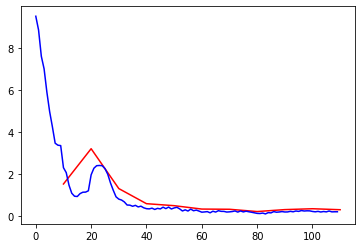

In [ ]:
#lossのグラフ化グラフ化
import matplotlib as mpl
import matplotlib.pyplot as plt

a=len(loss_list)/len(acc_loss)
x = [i for i in range(len(loss_list))]
y = loss_list
x2 = [(i+1)*a for i in range(len(acc_loss))]
y2 = acc_loss

plt.plot(x2,y2,color="r") # 点列(x,y)を黒線で繋いだプロット

plt.plot(x,y,color="b") # 点列(x,y)を黒線で繋いだプロット
#plt.plot(x,y2,color="k") # 点列(x,y)を黒線で繋いだプロット
plt.show() # プロットを表示

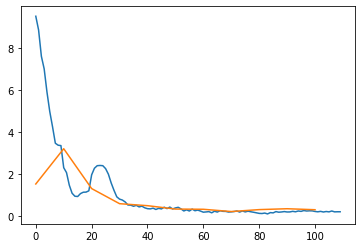

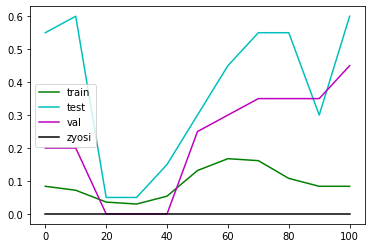

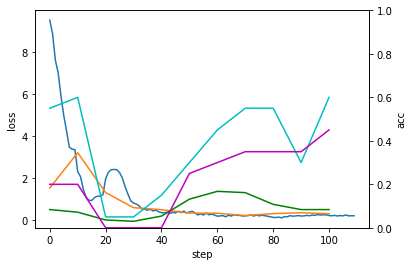

In [ ]:
#lossのグラフ化グラフ化
import matplotlib as mpl
import matplotlib.pyplot as plt

a=len(loss_list)/len(acc_loss)
x = [i for i in range(len(loss_list))]
y = loss_list
x2 = [(i)*a for i in range(len(acc_loss))]
y2 = acc_loss
y3 = train_acc_score
y4 = test_acc_score
y5 = val_acc_score
y6 = zyosi_acc_score
# plt.plot(x,y,color="b")
# plt.plot(x2,y2,color="r") 

plt.plot(x,y)
plt.plot(x2,y2)
plt.show()



plt.plot(x2,y3,color="g",label="train")
plt.plot(x2,y4,color="c",label="test")
plt.plot(x2,y5,color="m",label="val")
plt.plot(x2,y6,color="k",label="zyosi")
plt.legend()
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(x,y)
ax1.plot(x2,y2)
ax2.plot(x2,y3,color="g")
ax2.plot(x2,y4,color="c")
ax2.plot(x2,y5,color="m")
plt.ylim(0,1)
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
ax2.set_ylabel('acc')
#plt.plot(x,y2,color="k") # 点列(x,y)を黒線で繋いだプロット
plt.show() # プロットを表示

## テストデータに対する予測

In [ ]:
model.eval()
count = 0
correctAnswer = []

with torch.no_grad():
  outputs = model(test_input)

masked_position = (test_input.squeeze() == tokenizer.mask_token_id).nonzero() #これでマスク部分の抽出ができるらしい
last_hidden_state = outputs[0].squeeze()#出力

masked_pos = []
[masked_pos.append([])for _ in range(masked_position[-1][0]+1)]

for i in masked_position:
    masked_pos[i[0].item()].append(i[1].item())


topk = 1
for index,mask_index in enumerate(masked_pos):
  result=[]
  answer=[]
  
  for i in mask_index:
    mask_hidden_state = last_hidden_state[index][i] # 詳細結果の参照
    idx = torch.topk(mask_hidden_state, k=topk, dim=0)[1] # 予測結果の上位を出力
    words = [tokenizer.decode(i.item()).strip() for i in idx]
    result.append(words[0])
    answer_words = tokenizer.decode(Test_labels[index][i].item()).strip()
    answer.append(answer_words)

  result_docs = test_docs_singele[index]
  for i in result:
    i=i.replace(" ","")
    result_docs = result_docs.replace('[MASK]',i,1)
  print("------------")
  print("maskに対する予測",result)
  print("答え答え　　　　 ",answer)
  print("予測した文章　:"+result_docs.replace("\n",""))
  print("元の文章　　　:"+test_labels[index].replace("\n",""))
  if(MatchList(result,answer)):
    count += 1
    correctAnswer.append(result_docs.replace("\n",""))
    
    # result_docs = [result_docs]
    # label_docs = [train_labels[batch*b:batch*c][index]]
    # F1 = calc_bert_score(result_docs, label_docs)

------------
maskに対する予測 ['必 要']
答え答え　　　　  ['必 要']
予測した文章　:お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)が必要です。
元の文章　　　:お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」（度胸、読経）が必要です。
------------
maskに対する予測 ['あ り']
答え答え　　　　  ['あ り']
予測した文章　:忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)があります。
元の文章　　　:忍者とかけまして、栗とときます。その心は、どちらも、「いが」（伊賀、イガ）があります。
------------
maskに対する予測 ['必 要']
答え答え　　　　  ['必 要']
予測した文章　:天秤とかけまして、赤ちゃんとときます。その心は、どちらも、「おもり」(重り、お守り)が必要です。
元の文章　　　:天秤とかけまして、赤ちゃんとときます。その心は、どちらも、「おもり」（重り、お守り）が必要です。
------------
maskに対する予測 ['良 い']
答え答え　　　　  ['あ る']
予測した文章　:自転車とかけまして、新聞とときます。その心は、どちらも、「ほうち」(放置、報知)が良いでしょう。
元の文章　　　:自転車とかけまして、新聞とときます。その心は、どちらも、「ほうち」（放置、報知）があるでしょう。
------------
maskに対する予測 ['、']
答え答え　　　　  ['あ り']
予測した文章　:花火とかけまして、仕事終わりとときます。その心は、どちらも、「うちあげ」(打ち上げ)が、ます。
元の文章　　　:花火とかけまして、仕事終わりとときます。その心は、どちらも、「うちあげ」（打ち上げ）があります。
------------
maskに対する予測 ['、']
答え答え　　　　  ['ほ し い']
予測した文章　:柔道とかけまして、禁煙とときます。その心は、どちらも、「いっぽん」(一本)が、です。
元の文章　　　:柔道とかけまして、禁煙とときます。その心は、どちらも、「いっぽん」（一本）がほしいです。
------------
maskに対する予測 ['あ り']
答

In [ ]:
print(count,len(test_input))
print(count/len(test_input))

6 20
0.3


In [ ]:
for i in correctAnswer:
  print(i)

お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)が必要です。
忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)があります。
天秤とかけまして、赤ちゃんとときます。その心は、どちらも、「おもり」(重り、お守り)が必要です。
株式とかけまして、お皿とときます。その心は、どちらも、「とうき」(投機、陶器)があります。
食堂とかけまして、不祥事事件とときます。その心は、どちらも、「ていしょく」(定食、停職)があります。
洋食とかけまして、丸とときます。その心は、どちらも、「はし」(箸、端)がありません。


In [ ]:
model.eval()
count = 0
correctAnswer=[]
for ind,j in enumerate(all_add_ZYOSI):
  fill_mask = pipeline("fill-mask",model=model,tokenizer=tokenizer)
  result = fill_mask(j)

  
  save_score = 0
  answer = ""
  token = ""
  top_zyosi_index = 0
  #助詞に対する推測が一番のものを見つける
  for ind2,results in enumerate(result):
    #print(results[0]['score'],results[0]['sequence'])
    if save_score==0:
      save_score = results[0]['score']
      answer = results[0]['sequence']
      token = results[0]['token_str']
      top_zyosi_index = ind2 
    else:
      if(save_score < results[0]['score']):
        save_score = results[0]['score']
        answer = results[0]['sequence']
        token = results[0]['token_str']
        top_zyosi_index = ind2 
  left_mask_index0 = torch.where(zyosi_input_list[ind][top_zyosi_index]==24)
  top_zyosi = tokenizer.decode(zyosi_input_list[ind][top_zyosi_index][left_mask_index0[0]+1].item()).strip()

  left_mask_index = torch.where(Test_labels[ind]==24)
  answer_words1 = tokenizer.decode(Test_labels[ind][left_mask_index[0]+1].item()).strip()
  answer_words2 = tokenizer.decode(Test_labels[ind][left_mask_index[0]+2].item()).strip()
  if MatchList([top_zyosi,token],[answer_words1.replace(" ",""),answer_words2.replace(" ","")]):
    count += 1
    correctAnswer.append(answer.replace(" ",""))
  print("------------")
  print("maskに対する予測",top_zyosi,token)
  print("答え　　　　 ",answer_words1.replace(" ",""),answer_words2.replace(" ",""))
  print("予測した文章　:"+answer.replace(" ",""))
  print("元の文章　　　:"+test_labels[ind].replace("\n",""))

------------
maskに対する予測 を 積ん
答え　　　　  が 必要
予測した文章　:お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」(度胸、読経)を積んです。
元の文章　　　:お化け屋敷とかけまして、お坊さんとときます。その心は、どちらも、「どきょう」（度胸、読経）が必要です。
------------
maskに対する予測 が つき
答え　　　　  が あり
予測した文章　:忍者とかけまして、栗とときます。その心は、どちらも、「いが」(伊賀、イガ)がつきます。
元の文章　　　:忍者とかけまして、栗とときます。その心は、どちらも、「いが」（伊賀、イガ）があります。
------------
maskに対する予測 が 必要
答え　　　　  が 必要
予測した文章　:天秤とかけまして、赤ちゃんとときます。その心は、どちらも、「おもり」(重り、お守り)が必要です。
元の文章　　　:天秤とかけまして、赤ちゃんとときます。その心は、どちらも、「おもり」（重り、お守り）が必要です。
------------
maskに対する予測 よ り 良い
答え　　　　  が ある
予測した文章　:自転車とかけまして、新聞とときます。その心は、どちらも、「ほうち」(放置、報知)より良いでしょう。
元の文章　　　:自転車とかけまして、新聞とときます。その心は、どちらも、「ほうち」（放置、報知）があるでしょう。
------------
maskに対する予測 や 、
答え　　　　  が あり
予測した文章　:花火とかけまして、仕事終わりとときます。その心は、どちらも、「うちあげ」(打ち上げ)や、ます。
元の文章　　　:花火とかけまして、仕事終わりとときます。その心は、どちらも、「うちあげ」（打ち上げ）があります。
------------
maskに対する予測 が 必要
答え　　　　  が ほしい
予測した文章　:柔道とかけまして、禁煙とときます。その心は、どちらも、「いっぽん」(一本)が必要です。
元の文章　　　:柔道とかけまして、禁煙とときます。その心は、どちらも、「いっぽん」（一本）がほしいです。
------------
maskに対する予測 が つき
答え　　　　  が き
予測した文章　:クリーニング屋とかけまして、笑顔とときます。その心は

KeyboardInterrupt: ignored

In [ ]:
print(count,len(test_input))
print(count/len(test_input))

In [ ]:
for i in correctAnswer:
  print(i)